<a href="https://colab.research.google.com/github/aanchal0431/chatbot/blob/main/SEP_728_Chatbot_Questiontype_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.7.0


Git Commands to clone repository, pull and push data

In [3]:
!git clone https://github.com/aanchal0431/chatbot.git
#!git pull
%cd chatbot/
#!git config --global user.name "aanchal0431"
#!git config --global user.email "aanchal0431@gmail.com"
#!git remote add aanchal0431 https://github.com/aanchal0431/chatbot.git
#!git --help
#!git remote -v
#!git init
#%ls
#!git add outputs/
!git status 
#!git commit -m 'Model epoch 1'


Cloning into 'chatbot'...
remote: Enumerating objects: 757, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 757 (delta 88), reused 178 (delta 35), pack-reused 486
Receiving objects: 100% (757/757), 8.25 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/chatbot
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


### Data Preprocessing - **Cleaning**

*   Load datasets
*   Append question and answer datasets
*   Remove questions with no answers
*   Drop irrelevant columns
*   Remove duplicate questions
*   Convert data to lower case
*   Add context

In [4]:
cur_path = 'Data/Question_Answer_Dataset_v1.2/'
data_s8 = pd.read_csv(cur_path + 'S08/question_answer_pairs.txt', delimiter="\t")
data_s9 = pd.read_csv(cur_path + 'S09/question_answer_pairs.txt', delimiter="\t")
data_s10 = pd.read_csv(cur_path + 'S10/question_answer_pairs.txt', delimiter="\t")
print("Shape s8:", data_s8.shape)
print("Shape s9:", data_s9.shape)
print("Shape s10:", data_s10.shape)
data_s8.head()

Shape s8: (1715, 6)
Shape s9: (825, 6)
Shape s10: (1458, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Append Data

In [5]:
#append all questions into one data set
data_all = data_s8.append(data_s9.append(data_s10))
print("Shape:", data_all.shape)
data_all.head()


Shape: (3998, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Drop irrelevant columns and remove questions without an answer

In [6]:
#remove irrelevant columns
data_all = data_all.drop(labels = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis = 1)

#drop rows with NULL values
data_all = data_all.dropna(subset=['Answer'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (3422, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Remove duplicate questions

In [7]:
#remove duplicate questions
data_all = data_all.drop_duplicates(subset=['Question'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (2203, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
4,Abraham_Lincoln,Did his mother die of pneumonia?,no
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832


Convert all text to lower case

In [8]:
# convert text to lower case
data_all = data_all.apply(lambda x: x.astype(str).str.lower())
data_all.head()

,ArticleTitle,Question,Answer
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes
2,abraham_lincoln,did lincoln sign the national banking act of 1...,yes
4,abraham_lincoln,did his mother die of pneumonia?,no
6,abraham_lincoln,how many long was lincoln's formal education?,18 months
8,abraham_lincoln,when did lincoln begin his political career?,1832


Load Wikipedia article and add to the dataframe

In [9]:
#Add a column containing the context
#create dataset with column
title = []
context = []

#pull context and titles from S08
for y in range (8, 11):   
  for s in range(1, 7):
    for a in range(1, 11):
      file = str('Data/Question_Answer_Dataset_v1.2/S0' + str(y) + '/data/set' + str(s) + '/a' + str(a) + '.txt.clean' )
      if os.path.exists(file):
        article = open(file, encoding = "ISO-8859-1").read()
        context.append(article)
        title.append(article.split('\n')[0])

#create dataframe for context and titles
data_articles = pd.DataFrame({'ArticleTitle': title,
                              'Context': context})

#make lower case
data_articles = data_articles.apply(lambda x: x.astype(str).str.lower())

print("Shape:", data_articles.shape)
data_articles.head()

Shape: (90, 2)


,ArticleTitle,Context
0,kangaroo,kangaroo\n\n\na kangaroo is a marsupial from t...
1,leopard,leopard\n\n\n\nthe leopard (panthera pardus) i...
2,penguin,penguin\n\n\n\na penguin encounters a human du...
3,polar bear,polar bear\n\n\n\nthe polar bear (ursus mariti...
4,elephant,elephant\n\n\n\nelephants (elephantidae) are a...


In [10]:
#replace all _ in titles with spaces
data_all['ArticleTitle'] = data_all['ArticleTitle'].str.replace('_', ' ')
data_articles['ArticleTitle'] = data_articles['ArticleTitle'].str.replace('_', ' ')

#join context into data all
data_all = data_all.merge(data_articles, how='left', on='ArticleTitle')

print("Shape:", data_all.shape)
data_all.head()

Shape: (2755, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...


### Explore Data
Check the word length of the answers. How many questions are yes/no questions? What type of question is asked most often?

Single word answers: 1575
Two word answers: 231
Three word answers: 161
Four word answers: 124
Five word answers: 88
6-10 word answers: 341
11-20 word answers: 186
More than 20 words answers: 49

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

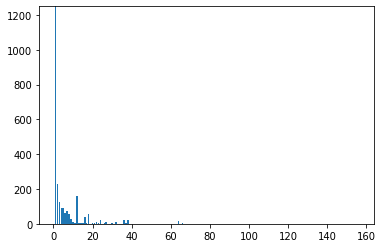

In [11]:
#plot the distribution of answer word length
word_length = data_all['Answer'].str.count(' ') + 1
string_length = data_all['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,1250])
plt.show

In [12]:
#examine types of questions
question_type = data_all['Question'].str.split(' ').str[0]
question_type.value_counts()

what         564
is           395
was          247
how          196
did          193
            ... 
whate          1
over           1
drums          1
qatar          1
different      1
Name: Question, Length: 102, dtype: int64

In [13]:
#pull all yes/no questions
yes_no = ['yes', 'yes.', 'yes,', 'no', 'no.', 'no,']
data_yn = data_all.where(data_all['Answer'].str.split(' ').str[0].isin(yes_no)).dropna()
data_yn['Answer'] = data_yn['Answer'].str.split(' ').str[0]

#remove periods & commas
data_yn['Answer'] = data_yn['Answer'].str.replace('.','')
data_yn['Answer'] = data_yn['Answer'].str.replace(',','')

print("Shape:", data_yn.shape)
data_yn.head()

Shape: (1070, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...


In [14]:
#pull all other questions that pull "direct" answers from the context
data_context = data_all.where((data_all['Answer'].str.split(' ').str[0].isin(yes_no)) == False).dropna()
data_context.to_csv('Questions_toClean.csv', index=False)
print("Shape:", data_context.shape)
data_context.head()

Shape: (1252, 4)


,ArticleTitle,Question,Answer,Context
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...
5,abraham lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",abraham lincoln\n\n\n\nabraham lincoln (februa...
6,abraham lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,abraham lincoln\n\n\n\nabraham lincoln (februa...
7,abraham lincoln,when did the gettysburg address argue that ame...,1776,abraham lincoln\n\n\n\nabraham lincoln (februa...


Single word answers: 363
Two word answers: 197
Three word answers: 141
Four word answers: 99
Five word answers: 69
6-10 word answers: 236
11-20 word answers: 116
More than 20 words answers: 31

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

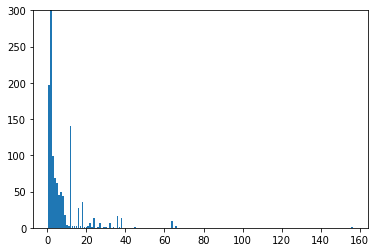

In [15]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Answer'].str.count(' ') + 1
string_length = data_context['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,300])
plt.show

In [17]:
#create type indicator in data set and combine clean yes/no and context
data_yn['Answer Type'] = '1'
data_context['Answer Type'] = '0'
data_all = data_yn.append(data_context)

print("Shape:", data_all.shape)
print("Shape of Yes/No questions:", data_yn.shape)
print("Shape of Context questions:", data_context.shape)
data_all.head()

print(type(data_all))
df = data_all.iloc[2311]
print(df)


Shape: (2322, 5)
Shape of Yes/No questions: (1070, 5)
Shape of Context questions: (1252, 5)
<class 'pandas.core.frame.DataFrame'>
ArticleTitle                                               violin
Question        what is a person that makes or repairs violins...
Answer                                                    luthier
Context         violin\n\n\n\nthe violin is a bowed string ins...
Answer Type                                                     0
Name: 2724, dtype: object


### Data Preprocess - Model preparation

In [18]:
# split yes/no question answers into train test dataset
X_train_yn, X_test_yn, y_train_yn, y_test_yn = train_test_split(list(data_all['Question']), list(data_all['Answer Type']),
          shuffle=True, test_size=0.1, random_state=5)

vocab_size = 10000
trunc_type =  'post'
padding_type = 'post'

In [19]:
#Tokenization Example for Questions/Answers
# import APIs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") #oov: out of vocabulary token => used to handle newly encountered words in the training dataset, new

#creating word index
tokenizer.fit_on_texts(X_train_yn)
word_index = tokenizer.word_index
max_len = len(word_index) + 1
print(max_len)

# method to tokenize text data
def tokenize_text(text, vocab_size, max_len, trunc_type, padding_type):
  #create sequences using tokenizer
  sequences = tokenizer.texts_to_sequences(text)

  #padding the sequences to make sure length matches for all the sequences
  padded_sequences = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

  print(padded_sequences.shape)
  return padded_sequences


3320


In [20]:
# Tokenization example for all the Yes No Questions/Answers in the dataset

train_sequences_ques = tokenize_text(X_train_yn, vocab_size, max_len, trunc_type, padding_type)
# train_sequences_ans = tokenize_text(y_train_yn, vocab_size, max_len, trunc_type, padding_type)
test_sequences_ques = tokenize_text(X_test_yn, vocab_size, max_len, trunc_type, padding_type)
# test_sequences_ans = tokenize_text(y_test_yn, vocab_size, max_len, trunc_type, padding_type)

(2089, 3320)
(233, 3320)


### LSTM - Implementation for Yes/No questions

In [21]:
# Need this block to get it to work with TensorFlow 2.x
# import numpy as np
training_padded = np.array(train_sequences_ques)
testing_padded = np.array(test_sequences_ques)

y_train_yn = np.asarray(y_train_yn).astype('float32').reshape((-1,1))
y_test_yn = np.asarray(y_test_yn).astype('float32').reshape((-1,1))
print(training_padded.shape)
print(y_train_yn.shape)
print(testing_padded.shape)
print(y_test_yn.shape)


(2089, 3320)
(2089, 1)
(233, 3320)
(233, 1)


In [22]:
# Bi-directional LSTM model with 64 and 32 layers to classify the question as yes/no or context based
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# binary_cross entropy as loss for textual data
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [23]:
history = model.fit(training_padded,
                    y_train_yn,
                    epochs=10,
                    validation_data=(testing_padded, y_test_yn),
                    verbose=2)

Epoch 1/10
66/66 - 397s - loss: 0.6455 - accuracy: 0.6577 - val_loss: 0.3183 - val_accuracy: 0.9056 - 397s/epoch - 6s/step
Epoch 2/10
66/66 - 390s - loss: 0.1450 - accuracy: 0.9631 - val_loss: 0.1310 - val_accuracy: 0.9571 - 390s/epoch - 6s/step
Epoch 3/10
66/66 - 389s - loss: 0.0697 - accuracy: 0.9832 - val_loss: 0.1500 - val_accuracy: 0.9056 - 389s/epoch - 6s/step
Epoch 4/10
66/66 - 388s - loss: 0.0389 - accuracy: 0.9919 - val_loss: 0.1005 - val_accuracy: 0.9614 - 388s/epoch - 6s/step
Epoch 5/10
66/66 - 391s - loss: 0.0187 - accuracy: 0.9962 - val_loss: 0.1182 - val_accuracy: 0.9700 - 391s/epoch - 6s/step
Epoch 6/10
66/66 - 390s - loss: 0.0222 - accuracy: 0.9947 - val_loss: 0.2316 - val_accuracy: 0.9485 - 390s/epoch - 6s/step
Epoch 7/10
66/66 - 389s - loss: 0.0149 - accuracy: 0.9976 - val_loss: 0.1377 - val_accuracy: 0.9657 - 389s/epoch - 6s/step
Epoch 8/10
66/66 - 389s - loss: 0.0081 - accuracy: 0.9990 - val_loss: 0.1724 - val_accuracy: 0.9614 - 389s/epoch - 6s/step
Epoch 9/10
66/66

Visualize accuracy and loss for the LSTM model

In [24]:
#function to visualiz results
def plot_results(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric])
  plt.title('Train and Validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)  
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

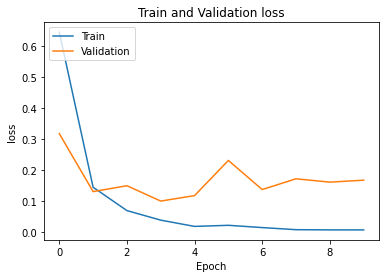

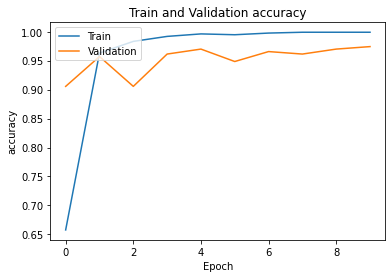

In [25]:
plot_results(history, "loss")
plot_results(history, "accuracy")

y_pred=model.predict(y_test_yn)


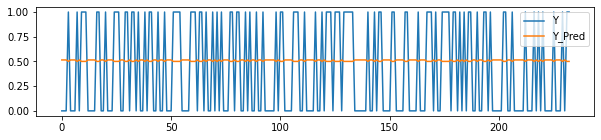

In [31]:
plt.figure(figsize=(10,2))
plt.plot(y_test_yn, label = 'Y')
plt.plot(y_pred, label = 'Y_Pred')
plt.legend()
plt.show()